# Bike Sharing Demand
## Michał Binda, Mikołaj Mróz, Paweł Swiderski

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import calendar
import seaborn as sn
from scipy import stats
# import missingno as msno
from datetime import datetime
import warnings
%matplotlib inline

In [73]:
df_train = pd.read_csv('train.csv',header = 0)
df_test = pd.read_csv('test.csv', header = 0)

In [74]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [75]:
X_train = df_train.iloc[:,:-1] 
y_train = df_train["count"]

### Functions

In [76]:
def modify_datetime(df):

    # We will simply extract year, month, day, weekday, and hour from the datetime feature
    df['year'] = pd.DatetimeIndex(df.datetime).year
    df['month'] = pd.DatetimeIndex(df.datetime).month
    df['day'] = pd.DatetimeIndex(df.datetime).day
    df['weekday'] = pd.DatetimeIndex(df.datetime).dayofweek
    df['hour'] = pd.DatetimeIndex(df.datetime).hour  
    return df

In [77]:
# def modify_datetime(df):
#     df['month'] = pd.DatetimeIndex(df.datetime).month
#     df['day'] = pd.DatetimeIndex(df.datetime).dayofweek
#     df['hour'] = pd.DatetimeIndex(df.datetime).hour
    
#     return df

In [78]:
def modify_to_category(df):
    categoryVariableList = ["hour","day","month","season","weather","holiday","workingday"]
    for var in categoryVariableList:
        df[var] = df[var].astype("category")
    
    return df

In [79]:
def drop_datetime(df):
    
    return df.drop(['datetime'],axis=1)
    

In [80]:
def replace_zero_windspeed_with_median(df):
    median_windspeed = df['windspeed'].median()
    df['windspeed'] = df['windspeed'].replace(0, median_windspeed)
    return df

In [81]:
# We can't use it, because mode(windspeed) = 0
# def replace_zero_windspeed_with_mode(df):
#     mode_windspeed = df['windspeed'].mode()
#     df['windspeed'] = df['windspeed'].replace(0, mode_windspeed)
#     return df


In [82]:
def replace_zero_humidity_with_mode(df):
    mode_humidity = df['humidity'].mode()[0]
    df['humidity'] = df['humidity'].replace(0, mode_humidity)
    return df



In [83]:
def preprocess(df):
    df = modify_datetime(df)
    df = df.drop('year', axis=1)
#     df = modify_to_category(df)
    df = drop_datetime(df)
    df = replace_zero_windspeed_with_median(df)
    df = replace_zero_humidity_with_mode(df)
    df = df.drop('day', axis=1)
    return df

## Data exploration

In [63]:
print("Rozmiar ramki: ", df_train.shape)

Rozmiar ramki:  (10886, 12)


### Checking NaN Values

In [64]:
nan_values = df_train[df_train.isna().any(axis=1)]
print(nan_values)

Empty DataFrame
Columns: [datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count]
Index: []


In [65]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

### Firstly, we'll check the types of features

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### We have to deal with datetime, namely convert it from object to something useful.

In [18]:
modify_datetime(df_train)
modify_datetime(df_test)

In [19]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### Let's look at the year column

In [20]:
df_train.year.unique()

array([2011, 2012])

In [21]:
df_train = df_train.drop('year', axis=1)


### There are only two years so we will drop the year column

### Dataframe contains of multiple columns, we will predict 'count' column. In order to do it we have to think of a way of handling object values

In [22]:

df_train2 = modify_to_category(df_train)
df_train2 = drop_datetime(df_train2)

In [23]:
df_train2.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,5,4


In [70]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  month       10886 non-null  category
 12  day         10886 non-null  category
 13  weekday     10886 non-null  int64   
 14  hour        10886 non-null  category
dtypes: category(7), float64(3), int64(5)
memory usage: 757.4 KB


### Let's see how the features are distributed

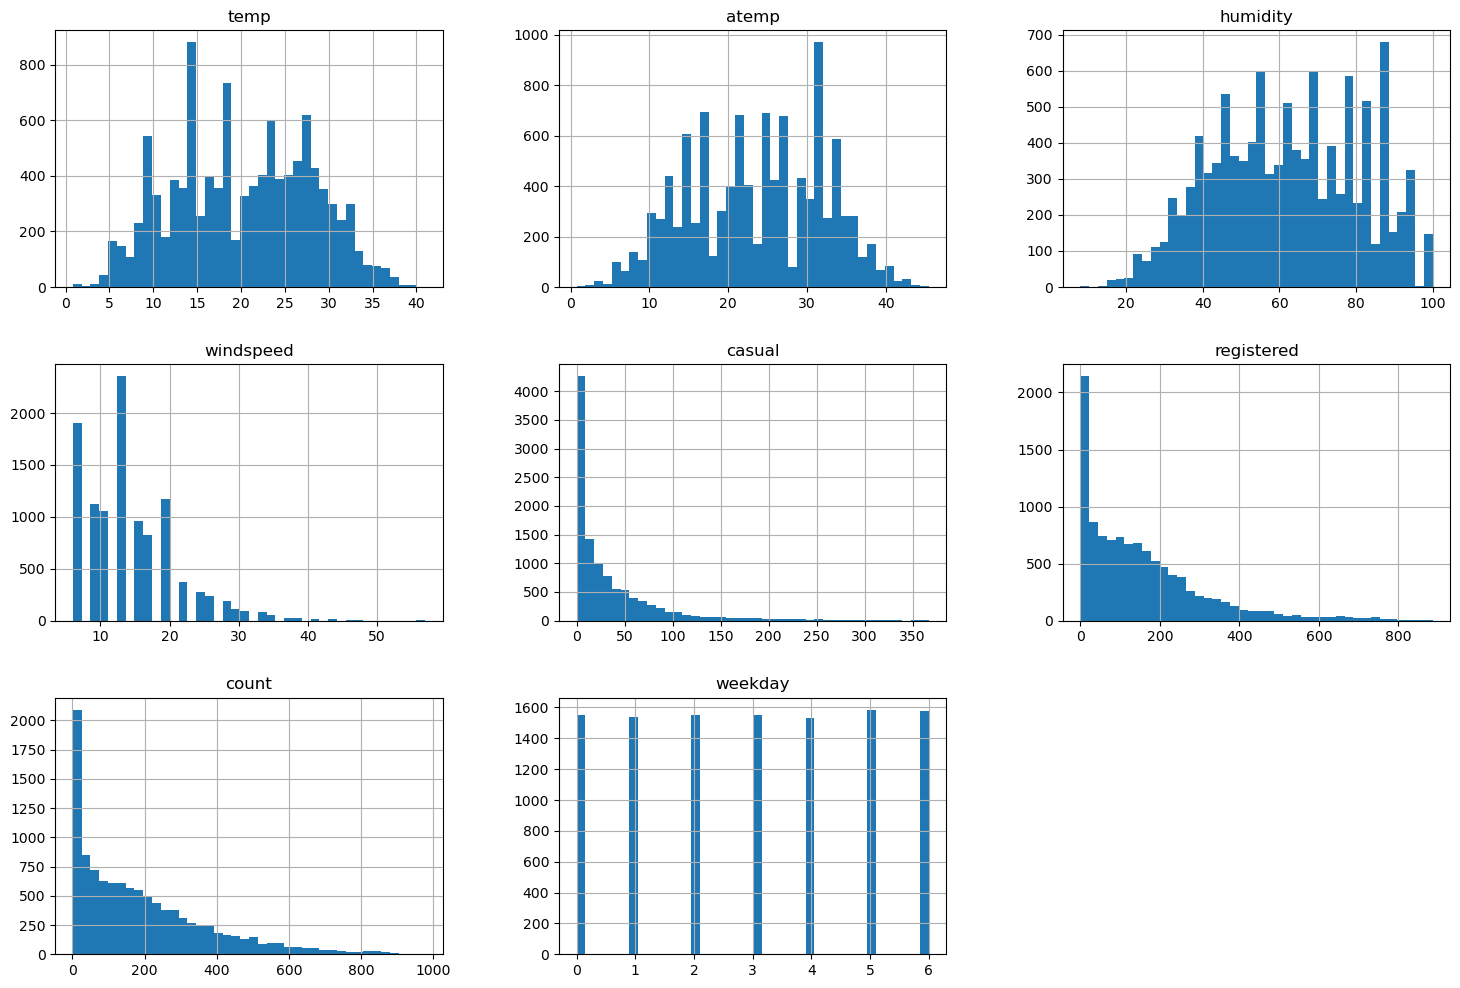

In [71]:
df_train2.hist(bins = 40, figsize=(18, 12))

plt.show()

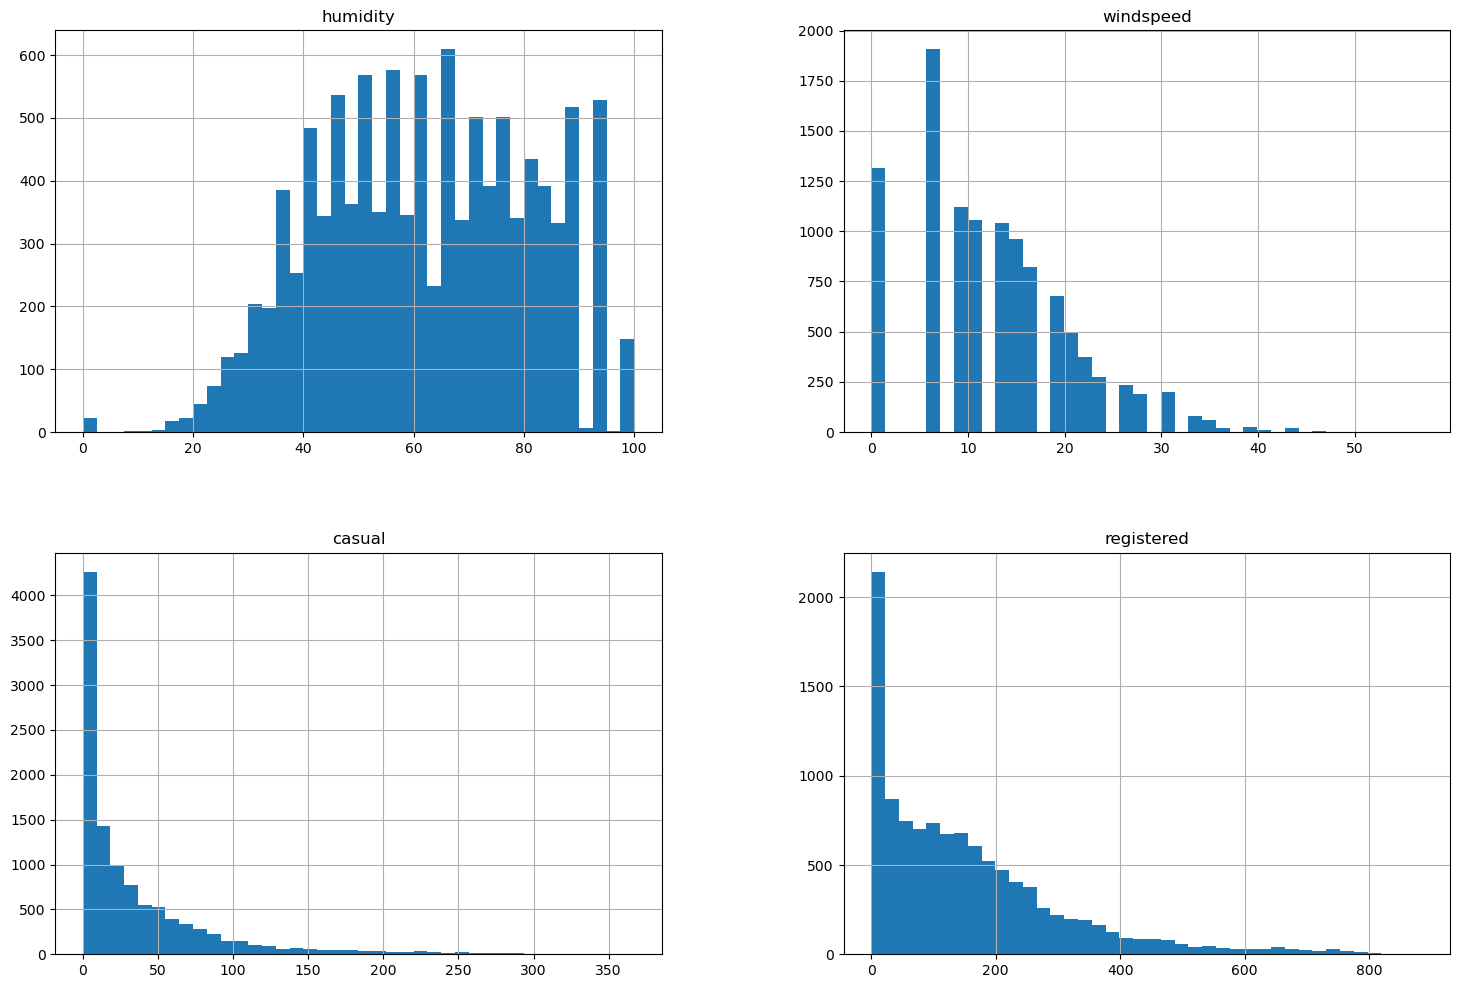

In [26]:
df_train.iloc[:, 7:11].hist(bins = 40, figsize=(18, 12))

plt.show()


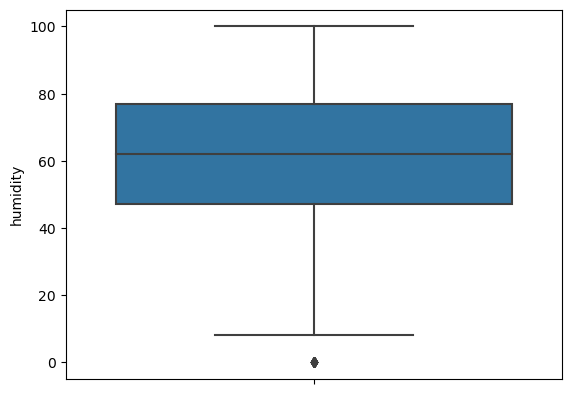

In [27]:
sn.boxplot(data = df_train.iloc[:, 7:11], y = "humidity")
plt.show()



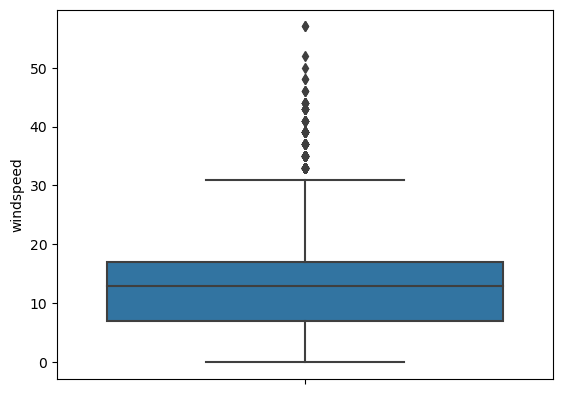

In [28]:
sn.boxplot(data = df_train.iloc[:, 7:11], y = "windspeed")
plt.show()

In [29]:
df_train3 = replace_zero_windspeed_with_median(df_train2)

In [30]:
df_train3 = replace_zero_humidity_with_mode(df_train3)

In [31]:
for col in df_train3.select_dtypes(include=["object"]).columns[:-1]:
    print(col)
print('----------------------------------------------')

names = df_train3['temp'].unique().tolist()
print(len(names))
print('unique temp')

names = df_train3['atemp'].unique().tolist()
print(len(names))
print('unique atemp')

names = df_train3['humidity'].unique().tolist()
print(len(names))
print('unique humidity')

names = df_train3['windspeed'].unique().tolist()
print(len(names))
print('unique windspeed')

names = df_train3['casual'].unique().tolist()
print(len(names))
print('unique casual')

names = df_train3['registered'].unique().tolist()
print(len(names))
print('unique registered')

names = df_train3['count'].unique().tolist()
print(len(names))
print('unique count')


names = df_train3['month'].unique().tolist()
print(len(names))
print('unique month')

names = df_train3['day'].unique().tolist()
print(len(names))
print('unique day')

names = df_train3['weekday'].unique().tolist()
print(len(names))
print('unique weekday')

names = df_train3['hour'].unique().tolist()
print(len(names))
print('unique hour')


----------------------------------------------
49
unique temp
60
unique atemp
88
unique humidity
27
unique windspeed
309
unique casual
731
unique registered
822
unique count
12
unique month
19
unique day
7
unique weekday
24
unique hour


In [32]:
unique_temp = df_train3['day'].unique()
print(unique_temp)


[1, 2, 3, 4, 5, ..., 15, 16, 17, 18, 19]
Length: 19
Categories (19, int64): [1, 2, 3, 4, ..., 16, 17, 18, 19]


### Let's see how the temp changes with the season

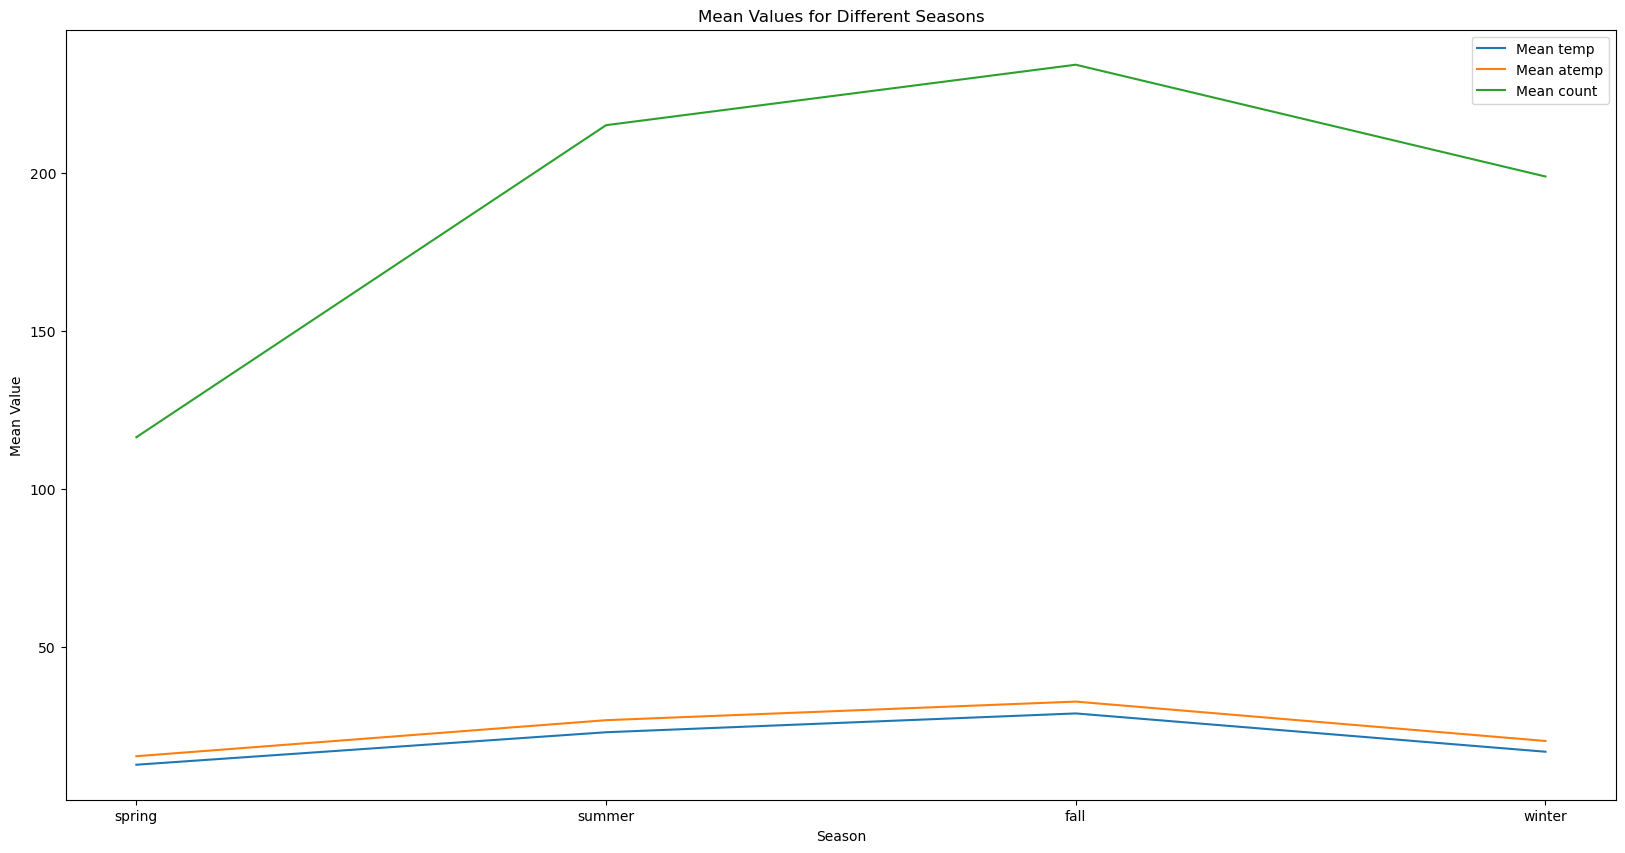

In [33]:
x = ["spring", "summer", "fall", "winter"]
y, y1, y2 = [], [], []

for i in range(1, 5):
    y.append(np.mean(df_train3[df_train3["season"] == i]["temp"].values.tolist()))
    y1.append(np.mean(df_train3[df_train3["season"] == i]["atemp"].values.tolist()))
    y2.append(np.mean(df_train3[df_train3["season"] == i]["count"].values.tolist()))

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Mean temp")
plt.plot(x, y1, label="Mean atemp")
plt.plot(x, y2, label="Mean count")
plt.legend()
plt.xlabel("Season")
plt.ylabel("Mean Value")
plt.title("Mean Values for Different Seasons")
plt.show()


### Let's how the count is distributed over the seasons

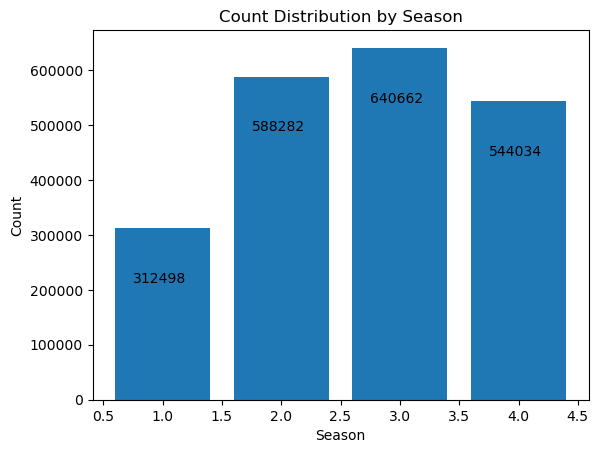

In [34]:
season_counts = df_train3.groupby('season')['count'].sum()

plt.bar(season_counts.index, season_counts.values)
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Count Distribution by Season')

# Annotate the count values on the bars
for i, count in enumerate(season_counts.values):
    plt.text(i + 1.2, count- 105000 , str(count), ha='right', va='bottom', fontsize=10)

plt.show()



### Let's see how the rental is distributed over the hours of the day

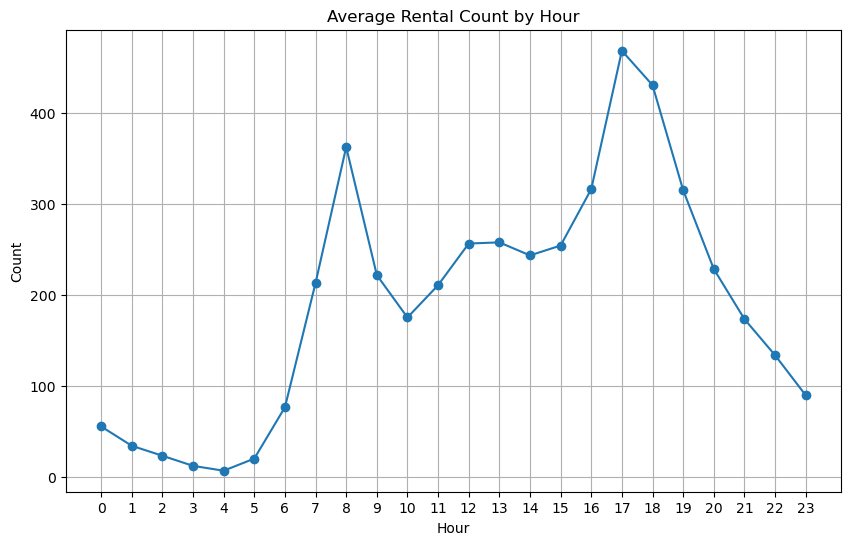

In [35]:

hourly_counts = df_train3.groupby('hour')['count'].mean()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linestyle='-')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Rental Count by Hour')
plt.xticks(hourly_counts.index)
plt.grid(True)
plt.show()


### Let's see how the rental is distributed over the months of the year


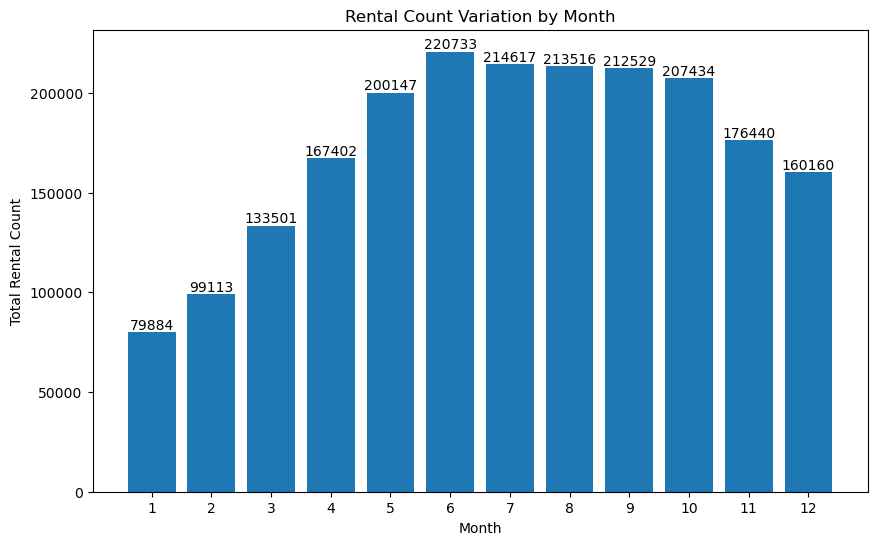

In [36]:

rental_count_per_month = df_train3.groupby('month')['count'].sum()
months = rental_count_per_month.index
count = rental_count_per_month.values

plt.figure(figsize=(10, 6))
bars = plt.bar(months, count, color = "blue")
plt.bar(months, count)
plt.xlabel('Month')
plt.ylabel('Total Rental Count')
plt.title('Rental Count Variation by Month')
plt.xticks(months)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.show()


### now we now preprocess went well so we preprocess the X_train dataset

In [84]:
df_preprocessed = preprocess(X_train)

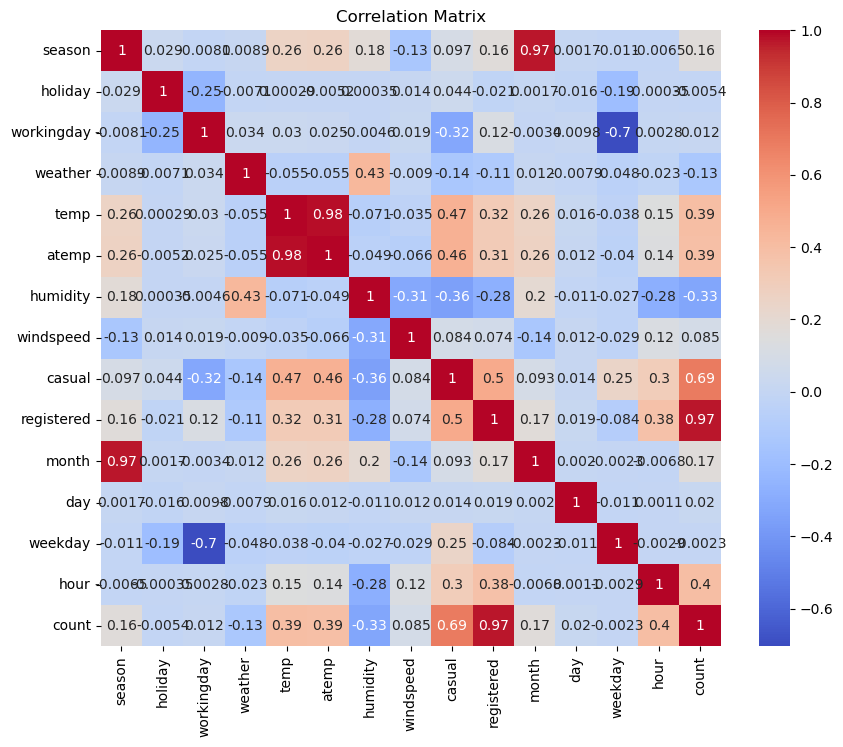

In [86]:


train_preprocessed = pd.concat([df_preprocessed, y_train], axis=1)


corr_matrix = train_preprocessed.corr()

# Plot correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Machine Learning Algorithm

In [34]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [39]:
#without cross validation
X_train = df_train4

linear_reg = LinearRegression()
decision_tree_reg = DecisionTreeRegressor()
random_forest_reg = RandomForestRegressor()

scores_linear_reg = cross_val_score(linear_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
scores_decision_tree_reg = cross_val_score(decision_tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
scores_random_forest_reg = cross_val_score(random_forest_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')



In [35]:
print(df_train4.dtypes)


season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
month         category
day           category
hour          category
dtype: object


In [36]:
df_train4.select_dtypes(include=['object'])


""
0
1
2
3
4
...
10881
10882
10883
10884


In [37]:
df_train4.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,12.998,3,13,16,1,5,0
1,1,0,0,1,9.02,13.635,80,12.998,8,32,40,1,5,1
2,1,0,0,1,9.02,13.635,80,12.998,5,27,32,1,5,2
3,1,0,0,1,9.84,14.395,75,12.998,3,10,13,1,5,3
4,1,0,0,1,9.84,14.395,75,12.998,0,1,1,1,5,4
